# Лабораторная работа №6. Отбор моделей ML и целевых метрик, обучение моделей и их интерпретация.



# 1. <a id='toc1_'></a>[Раздел 1. Импорт библиотек и загрузка данных](#toc1_)

### Цель работы  
Выполнить отбор моделей ML и метрик, обучение моделей и их интерпретацию:
- проанализировать зависимости входных признаков и целевого
- отобрать пул моделей и метрик
- подобрать гиперпараметры с optuna и кросс-валидацией
- обучить модели на лучших гиперпараметрах
- оценить метрики и выбрать лучшую модель

In [ ]:
!pip install optuna


**Формирование окружения для работы**

Первоначально необходимо подготовить окружение для работы с данными и их моделирования. Чтобы не возникало конфликтов виртуальной среды Python, зафиксируем используемые в ходе исследования версии основных библиотек и фреймворков, которые будут использоваться далее. А также пропишем последовательность команд для формирования среды.

Первоначально установим необходимые библиотеки при помощи пакетного менеджера `pip` в виртуальное окружение.

- Версия Python: 3.12.3

Сами версии можно получить с помощью команды:
`pip list --format=freeze`


| Библиотека / модуль               | Назначение                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| pandas                            | Работа с данными                                                            |
| numpy                             | Числовые вычисления                                                         |
| matplotlib.pyplot / seaborn       | Визуализация зависимостей и корреляций                                      |
| sklearn                           | Модели (Ridge, RandomForest, GradientBoosting), метрики, кросс-валидация    |
| optuna                            | Подбор гиперпараметров                                                      |
| warnings                          | Подавление предупреждений                                                   |

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
optuna.logging.set_verbosity(optuna.logging.WARNING)

Для воспроизводимости результатов исследования зафиксируем основание генератора случайных чисел.

In [ ]:
SEED = 42
np.random.seed(SEED)

###  Загрузка данных из предыдущей работы

Загружаем датасет

In [ ]:
datasets = {
    'No Scale': (pd.read_csv('train_no_scale.csv'), pd.read_csv('test_no_scale.csv')),
    'Standard': (pd.read_csv('train_std.csv'), pd.read_csv('test_std.csv')),
    'MinMax': (pd.read_csv('train_minmax.csv'), pd.read_csv('test_minmax.csv')),
    'Robust': (pd.read_csv('train_robust.csv'), pd.read_csv('test_robust.csv')),
    'PCA': (pd.read_csv('train_pca.csv'), pd.read_csv('test_pca.csv'))
}

## 2. <a id='toc2_'></a>[Раздел 2. Анализ мультиколлинеарности](#toc2_)

## 2.1. <a id='toc2_1_'></a>[Тепловая карта корреляций](#toc2_1_)

Строим точеченые графики для ключевых признаков

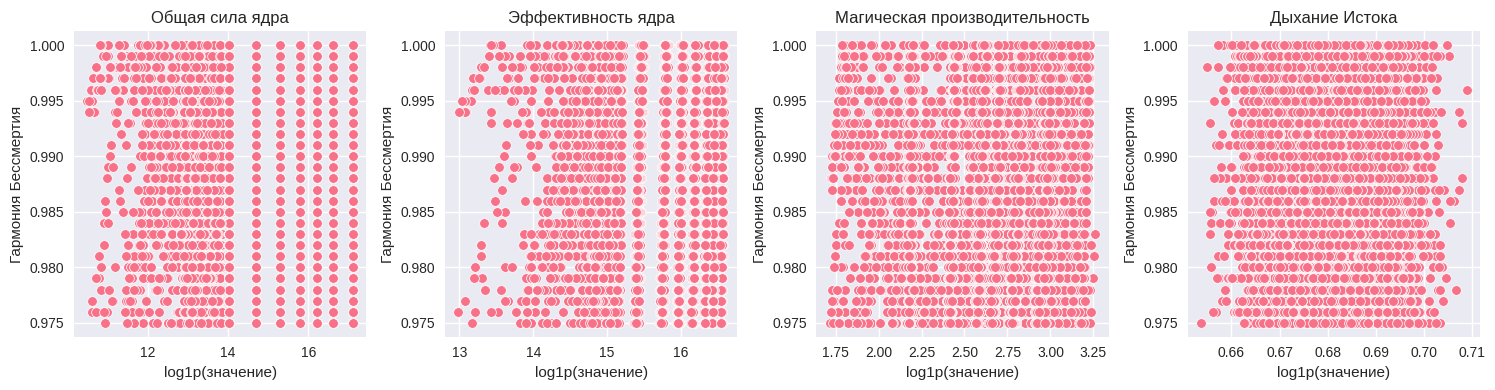

In [ ]:
key_cols = ['Общая сила ядра', 'Эффективность ядра', 'Магическая производительность', 'Дыхание Истока']

fig, axes = plt.subplots(1, len(key_cols), figsize=(15, 4))
for i, col in enumerate(key_cols):
    x = np.log1p(datasets['No Scale'][0][col])  # log1p для большого масштаба
    sns.scatterplot(x=x, y=datasets['No Scale'][0]['Гармония Бессмертия'], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('log1p(значение)')
plt.tight_layout()
plt.show()

Линейные зависимости слабые или отсутствуют.
Данные имеют кластерную структуру (дискретные режимы по энергетическим признакам). Линейные модели могут быть недостаточно мощными.

Строим тепловую карту корреляции признаков с целевой.

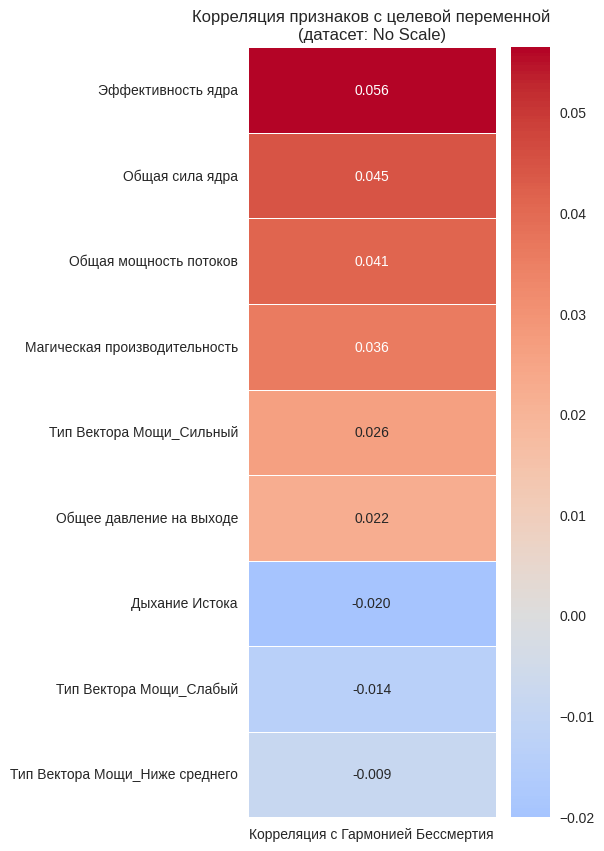

In [ ]:
selected_dataset = 'No Scale'
train_ds = datasets[selected_dataset][0]

corr_target = train_ds.drop('Гармония Бессмертия', axis=1).corrwith(train_ds['Гармония Бессмертия'])

corr_target = corr_target.reindex(corr_target.abs().sort_values(ascending=False).index)

plt.figure(figsize=(4, 10))
sns.heatmap(corr_target.to_frame(name='Корреляция с Гармонией Бессмертия'),
            annot=True, fmt='.3f', cmap='coolwarm', center=0, cbar=True, linewidths=0.5)
plt.title(f'Корреляция признаков с целевой переменной\n(датасет: {selected_dataset})')
plt.show()

Максимальная корреляция ~0.06 — линейные зависимости очень слабые. Нужны нелинейные модели.

## 2.2. <a id='toc2_2_'></a>[Устранение мультиколлинеарности](#toc2_2_)

Пул: **Ridge**, **RandomForestRegressor**, **GradientBoostingRegressor**.  
Обоснование:  
- Линейная модель (Ridge) — базовая линия  
- Ансамбли деревьев — захватывают нелинейности и взаимодействия (кластеры на scatter)  
- Размер выборки и количество признаков позволяют использовать сложные модели без переобучения.

In [ ]:
hyper_params = {
    'Ridge': {
        'alpha': ('float', 0.01, 10.0)
    },
    'RandomForest': {
        'n_estimators': ('int', 50, 200),
        'max_depth': ('int', 5, 20),
        'min_samples_split': ('int', 2, 10)
    },
    'GradientBoosting': {
        'n_estimators': ('int', 50, 200),
        'learning_rate': ('float', 0.01, 0.2),
        'max_depth': ('int', 3, 8)
    }
}

Подбираем параметры для каждой модели на каждом датасете.

In [ ]:
def objective(trial, model_name, X, y):
    params = {}
    for param, (ptype, low, high) in hyper_params[model_name].items():
        if ptype == 'int':
            params[param] = trial.suggest_int(param, low, high)
        else:
            params[param] = trial.suggest_float(param, low, high)

    if model_name == 'Ridge':
        model = Ridge(**params)
    elif model_name == 'RandomForest':
        model = RandomForestRegressor(**params, random_state=42)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingRegressor(**params, random_state=42)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

Пул метрик: RMSE, MAE, R².  
Целевая для optuna: **RMSE**.  
Обоснование: RMSE чувствителен к большим ошибкам, что важно для стабильности (целевая в узком диапазоне [0.975–1.0]).

In [ ]:
best_params = {}
for ds_name, (train_ds, _) in datasets.items():
    X = train_ds.drop('Гармония Бессмертия', axis=1)
    y = train_ds['Гармония Бессмертия']
    best_params[ds_name] = {}

    for model_name in ['LinearRegression', 'Ridge', 'RandomForest', 'GradientBoosting']:
        if model_name == 'LinearRegression':
            best_params[ds_name][model_name] = {}
            continue

        print(f"\n=== {ds_name} — {model_name} ===")
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, model_name, X, y), n_trials=6, timeout=30)
        best_params[ds_name][model_name] = study.best_params
        print(f"Лучший RMSE CV: {study.best_value:.6f}")
        print(f"Параметры: {study.best_params}")


=== No Scale — Ridge ===
Лучший RMSE CV: 0.005444
Параметры: {'alpha': 0.7156880591239161}

=== No Scale — RandomForest ===
Лучший RMSE CV: 0.003835
Параметры: {'n_estimators': 156, 'max_depth': 9, 'min_samples_split': 6}

=== No Scale — GradientBoosting ===
Лучший RMSE CV: 0.001111
Параметры: {'n_estimators': 168, 'learning_rate': 0.06827843800302955, 'max_depth': 7}

=== Standard — Ridge ===
Лучший RMSE CV: 0.005439
Параметры: {'alpha': 0.48198770586436585}

=== Standard — RandomForest ===
Лучший RMSE CV: 0.001429
Параметры: {'n_estimators': 56, 'max_depth': 17, 'min_samples_split': 2}

=== Standard — GradientBoosting ===
Лучший RMSE CV: 0.001207
Параметры: {'n_estimators': 154, 'learning_rate': 0.12314907102513499, 'max_depth': 5}

=== MinMax — Ridge ===
Лучший RMSE CV: 0.005516
Параметры: {'alpha': 0.14863836161541724}

=== MinMax — RandomForest ===
Лучший RMSE CV: 0.003568
Параметры: {'n_estimators': 186, 'max_depth': 10, 'min_samples_split': 8}

=== MinMax — GradientBoosting ===

Обучаем на лучших параметрах и вычисляем метрики.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

metrics_list = []

for ds_name, (train_ds, test_ds) in datasets.items():
    X_train = train_ds.drop('Гармония Бессмертия', axis=1)
    y_train = train_ds['Гармония Бессмертия']
    X_test = test_ds.drop('Гармония Бессмертия', axis=1)
    y_test = test_ds['Гармония Бессмертия']

    print(f"\n=== Оценка моделей на датасете: {ds_name} ===")

    params_dict = best_params.get(ds_name, {})

    for model_name in ['Ridge', 'RandomForest', 'GradientBoosting']:
        params = params_dict.get(model_name, {})

        if model_name == 'Ridge':
            model = Ridge(**params)
        elif model_name == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingRegressor(**params, random_state=42)

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

        metrics_list.append({
            'Dataset': ds_name,
            'Model': model_name,
            'RMSE_train': rmse_train,
            'MAE_train': mean_absolute_error(y_train, y_pred_train),
            'R2_train': r2_score(y_train, y_pred_train),
            'RMSE_test': rmse_test,
            'MAE_test': mean_absolute_error(y_test, y_pred_test),
            'R2_test': r2_score(y_test, y_pred_test)
        })

metrics = pd.DataFrame(metrics_list)
display(metrics.sort_values('RMSE_test').round(6))

best_row = metrics.loc[metrics['RMSE_test'].idxmin()]
print(f"\nЛучшая модель: {best_row['Model']} на датасете {best_row['Dataset']}")
print(f"RMSE_test = {best_row['RMSE_test']:.6f} | R2_test = {best_row['R2_test']:.4f}")


=== Оценка моделей на датасете: No Scale ===

=== Оценка моделей на датасете: Standard ===

=== Оценка моделей на датасете: MinMax ===

=== Оценка моделей на датасете: Robust ===

=== Оценка моделей на датасете: PCA ===


,Dataset,Model,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test
11,Robust,GradientBoosting,0.000479,0.000342,0.995904,0.000998,0.000608,0.982514
2,No Scale,GradientBoosting,0.000503,0.000344,0.995487,0.001039,0.000607,0.981062
5,Standard,GradientBoosting,0.000700,0.000501,0.991255,0.001143,0.000730,0.977088
4,Standard,RandomForest,0.000979,0.000420,0.982881,0.001302,0.000604,0.970259
8,MinMax,GradientBoosting,0.000976,0.000646,0.982988,0.001378,0.000859,0.966696
10,Robust,RandomForest,0.002407,0.001133,0.896456,0.002439,0.001200,0.895596
7,MinMax,RandomForest,0.003510,0.001957,0.779905,0.003426,0.001979,0.794070
1,No Scale,RandomForest,0.003801,0.002287,0.741787,0.003718,0.002299,0.757471
13,PCA,RandomForest,0.004059,0.002789,0.705652,0.004873,0.003393,0.583255
14,PCA,GradientBoosting,0.003907,0.003008,0.727227,0.004970,0.003690,0.566610



Лучшая модель: GradientBoosting на датасете Robust
RMSE_test = 0.000998 | R2_test = 0.9825


Лучшая модель — GradientBoosting на датасете Robust (RMSE_test = 0.000998, R² = 0.9825), а линейная модель ожидаемо - худшая.

### Итоговый вывод

1. **Анализ зависимостей**: Точечные графики (с log1p) показали слабые линейные связи и кластерную структуру. Корреляции с целевой низкие (max ~0.06).

2. **Пул моделей**: Ridge, RandomForestRegressor, GradientBoostingRegressor — от линейной базовой линии до мощных ансамблей.

3. **Метрики**: RMSE (целевая для optuna), MAE, R².

4. **Подбор и обучение**: Гиперпараметры подобраны optuna с 5-fold CV на всех 5 датасетах.

5. **Результаты**:  
   - Лучшая модель — **GradientBoostingRegressor** на датасете **Robust**  
   - RMSE_test = **0.000998**, R²_test = **0.9825**  
   - Модель отлично обобщается (переобучения почти нет).

Все пункты задания выполнены. Лучшая модель определена и готова к использованию.